Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 8 - Multi-Factor Models

## 8.1 Estimating the CAPM

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

2. Specify the risky asset, the benchmark, and the time horizon:

In [ ]:
RISKY_ASSET = "AMZN"
MARKET_BENCHMARK = "^GSPC"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download data from Yahoo Finance:

In [ ]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                #  adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


4. Resample to monthly data and calculate simple returns:

In [ ]:
X = (
    df["Adj Close"]
    .rename(columns={RISKY_ASSET: "asset", 
                     MARKET_BENCHMARK: "market"})
    .resample("M")
    .last()
    .pct_change()
    .dropna()
)
X.head()

,asset,market
Date,,
2016-02-29,-0.058739,-0.004128
2016-03-31,0.074423,0.065991
2016-04-30,0.111094,0.002699
2016-05-31,0.095817,0.015325
2016-06-30,-0.009920,0.000911


5. Calculate beta using the covariance approach: 

In [ ]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.1537107874315524

6. Prepare the input and estimate CAPM as a linear regression:

In [ ]:
# separate target
y = X.pop("asset")

# add constant
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     36.15
Date:                Wed, 31 May 2023   Prob (F-statistic):           1.37e-07
Time:                        04:23:46   Log-Likelihood:                 79.803
No. Observations:                  59   AIC:                            -155.6
Df Residuals:                      57   BIC:                            -151.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.009      2.182      0.0

Or, using the formula notation:

In [ ]:
import statsmodels.formula.api as smf

# rerun step 4 to have a DF with columns: `asset` and `market`
X = df["Adj Close"].rename(columns={RISKY_ASSET: "asset", 
                                    MARKET_BENCHMARK: "market"}) \
                   .resample("M") \
                   .last() \
                   .pct_change() \
                   .dropna()

# define and fit the regression model 
capm_model = smf.ols(formula="asset ~ market", data=X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     36.15
Date:                Wed, 31 May 2023   Prob (F-statistic):           1.37e-07
Time:                        04:23:46   Log-Likelihood:                 79.803
No. Observations:                  59   AIC:                            -155.6
Df Residuals:                      57   BIC:                            -151.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0188      0.009      2.182      0.0

### There's more

#### Risk-free rate (13 Week Treasury Bill)

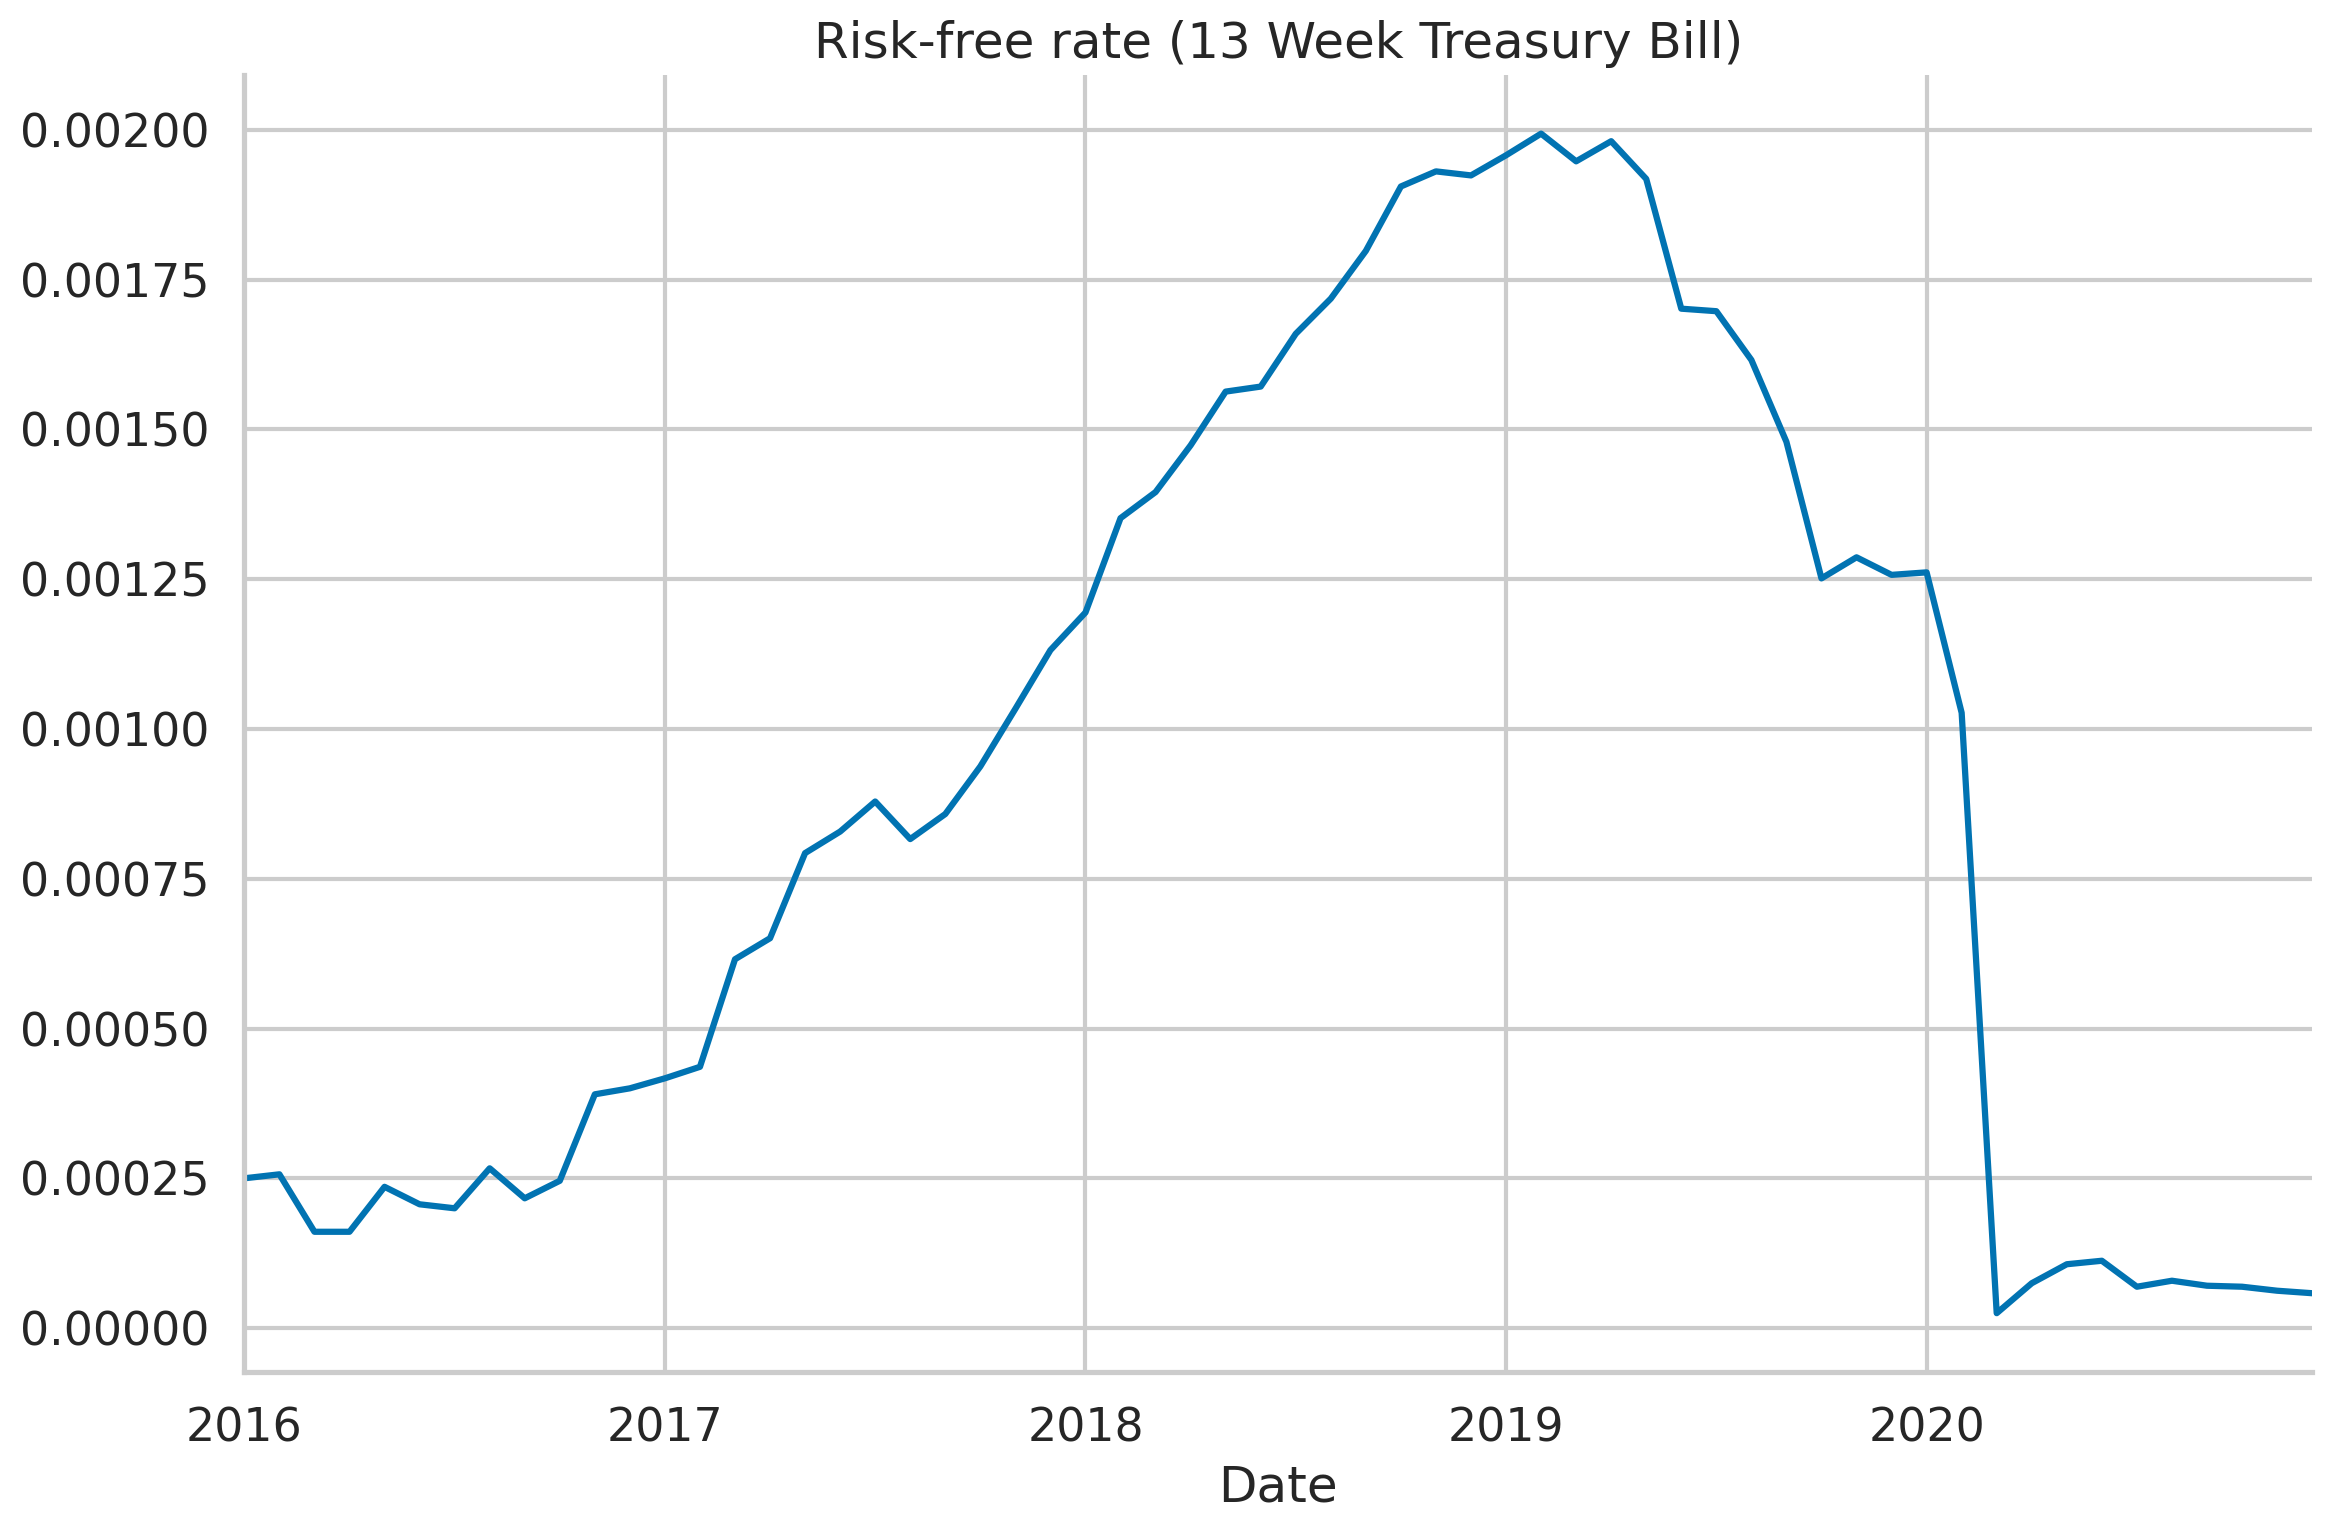

In [ ]:
# period length in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download("^IRX",
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample("M").last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1 

# plot the risk-free rate
rf.plot(title="Risk-free rate (13 Week Treasury Bill)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_2", dpi=200)

#### Risk-free rate (3-Month Treasury Bill)

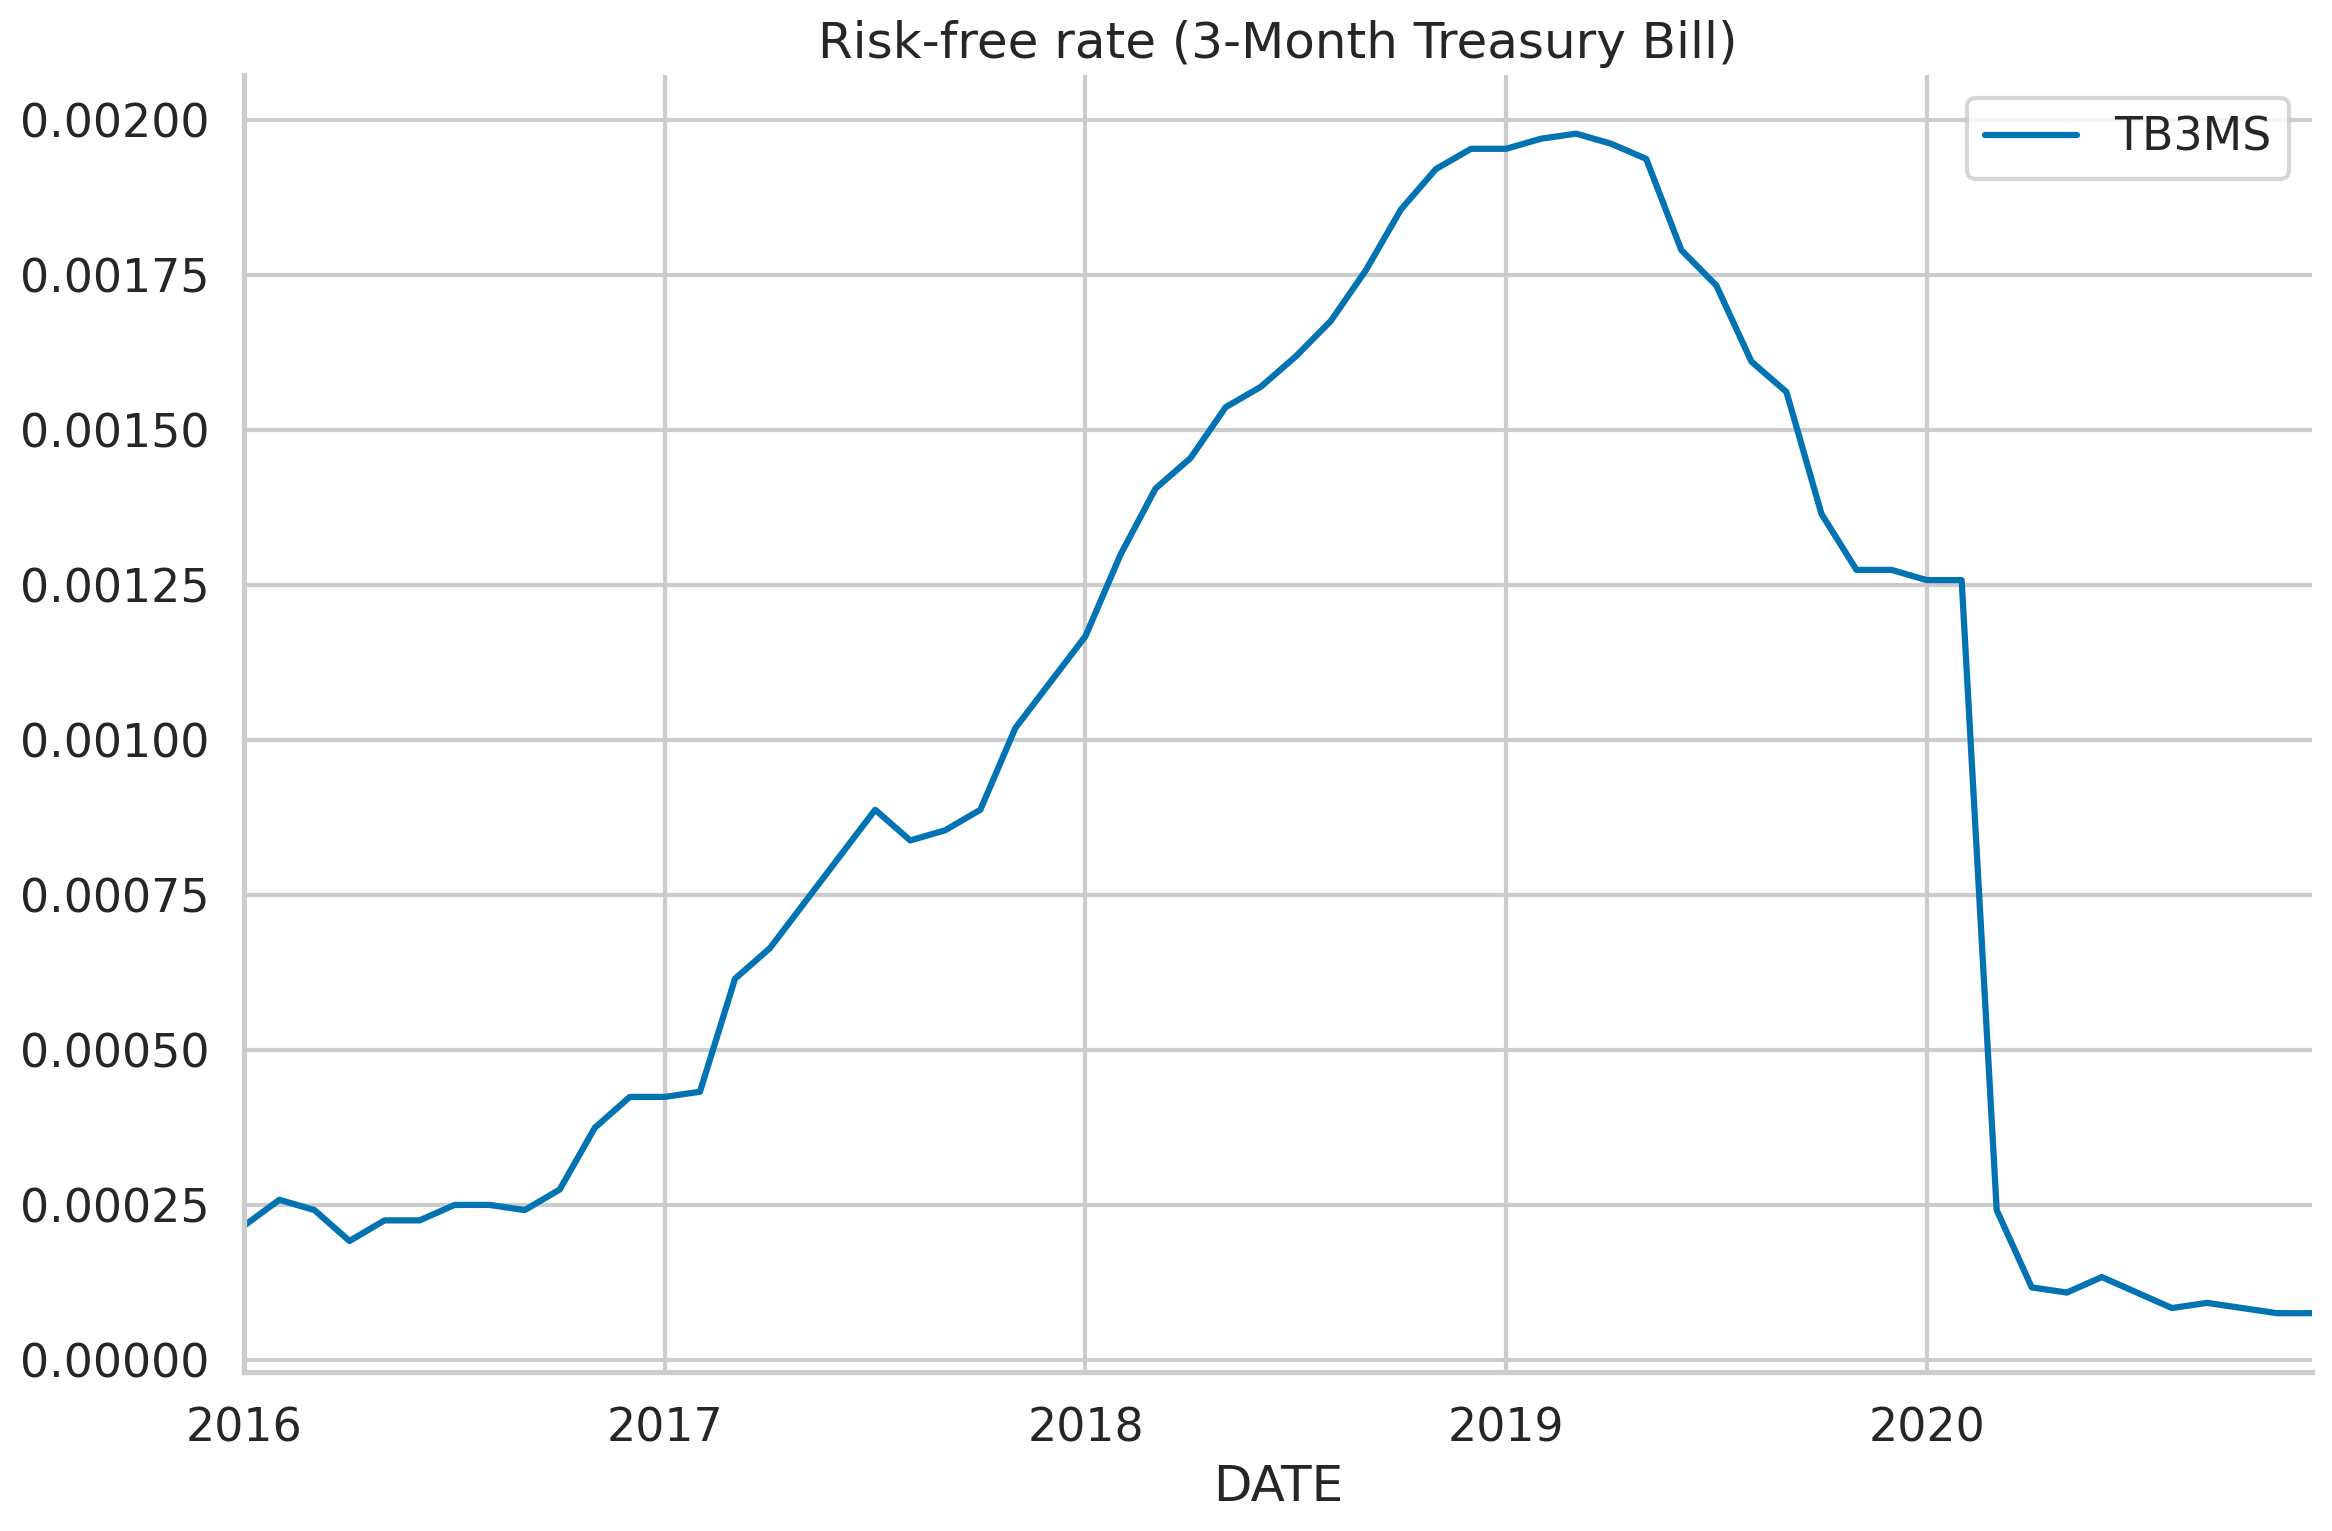

In [ ]:
import pandas_datareader.data as web

# download the data 
rf = web.DataReader(
    "TB3MS", "fred", start=START_DATE, end=END_DATE
)

# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1

# plot the risk-free rate
rf.plot(title="Risk-free rate (3-Month Treasury Bill)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_3", dpi=200)

## 8.2 Estimating the Fama-French three-factor model

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define parameters:

In [ ]:
RISKY_ASSET = "AAPL"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download the dataset containing the risk factors:

In [ ]:
ff_dict = web.DataReader("F-F_Research_Data_Factors", 
                         "famafrench", 
                         start=START_DATE,
                         end=END_DATE)

In [ ]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

In [ ]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202303 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2023 Kenneth R. French

  0 : (60 rows x 4 cols)
  1 : Annual Factors: January-December (5 rows x 4 cols)


4. Select the appropriate dataset and divide the values by 100:

In [ ]:
factor_3_df = ff_dict[0].rename(columns={"Mkt-RF": "MKT"}) \
                        .div(100)

factor_3_df.head()

,MKT,SMB,HML,RF
Date,,,,
2016-01,-0.0577,-0.0343,0.0209,0.0001
2016-02,-0.0007,0.0071,-0.0057,0.0002
2016-03,0.0696,0.0082,0.0119,0.0002
2016-04,0.0091,0.0074,0.0328,0.0001
2016-05,0.0178,-0.0018,-0.0166,0.0001


5. Download the prices of the risky asset:

In [ ]:
asset_df = yf.download(
    RISKY_ASSET,
    start=START_DATE,
    end=END_DATE,
    # adjusted=True,
    progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 2768 rows of data.


6. Calculate monthly returns on the risky asset:

In [ ]:
y = asset_df["Adj Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.to_period("m")
y.name = "rtn"
y.head()

Date
2010-02    0.065396
2010-03    0.148470
2010-04    0.111021
2010-05   -0.016124
2010-06   -0.020827
Freq: M, Name: rtn, dtype: float64

7. Merge the datasets and calculate excess returns:

In [ ]:
factor_3_df = factor_3_df.join(y)
factor_3_df["excess_rtn"] = (
    factor_3_df["rtn"] - factor_3_df["RF"]
)
factor_3_df.head()

,Mkt-RF,SMB,HML,RF,rtn,excess_rtn
Date,,,,,,
2010-01,-0.0336,0.0040,0.0043,0.0000,NaN,NaN
2010-02,0.0340,0.0119,0.0323,0.0000,0.065396,0.065396
2010-03,0.0631,0.0148,0.0221,0.0001,0.148470,0.148370
2010-04,0.0200,0.0487,0.0289,0.0001,0.111021,0.110921
2010-05,-0.0789,0.0009,-0.0244,0.0001,-0.016124,-0.016224


In [ ]:
factor_3_df.columns = ['MKT_RF', 'SMB', 'HML', 'RF', 'rtn', 'excess_rtn']

8. Estimate the three-factor model:

In [ ]:
# define and fit the regression model 
ff_model = smf.ols(formula="excess_rtn ~ MKT_RF + SMB + HML", 
                   data=factor_3_df).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     26.45
Date:                Wed, 31 May 2023   Prob (F-statistic):           2.34e-13
Time:                        04:25:33   Log-Likelihood:                 178.81
No. Observations:                 131   AIC:                            -349.6
Df Residuals:                     127   BIC:                            -338.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0091      0.006      1.558      0.1

### There's more

Print available datasets (here only first 5):

In [ ]:
from pandas_datareader.famafrench import get_available_datasets

get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

### Bonus

1. Download data from prof. French's website:

To do so, we used the fact that we can execute bash commands in Jupyter Notebooks by preceding them with `!`. First, we downloaded the file using wget and then unzipped it using unzip. There are also ways to do this in Python only, but this seemed like a good place to introduce the possibility of mixing up bash script into the Notebooks. The link to the monthly data is always the same, and the file is updated every month. 


In [ ]:
# download the zip file from Prof. French's website
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

# unpack the zip file
!unzip -a F-F_Research_Data_Factors_CSV.zip

# remove the zip file
!rm F-F_Research_Data_Factors_CSV.zip

--2023-05-31 04:25:44--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.136.60
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.136.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12711 (12K) [application/x-zip-compressed]
Saving to: ‘F-F_Research_Data_Factors_CSV.zip’

F-F_Research_Data_F 100%[===================>]  12.41K  --.-KB/s    in 0s      

2023-05-31 04:25:45 (230 MB/s) - ‘F-F_Research_Data_Factors_CSV.zip’ saved [12711/12711]

Archive:  F-F_Research_Data_Factors_CSV.zip
  inflating: F-F_Research_Data_Factors.CSV  [binary]


2. Load data from the source CSV file and keep only the monthly data:

In [ ]:
# load data from CSV
factor_3_df = pd.read_csv("/content/F-F_Research_Data_Factors.CSV", skiprows=3)

# identify where the annual data starts
STR_TO_MATCH = " Annual Factors: January-December "
indices = factor_3_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_3_df[indices].index[0]

# keep only monthly data
factor_3_df = factor_3_df[factor_3_df.index < start_of_annual]

3. Rename columns of the DataFrame, set a datetime index and filter by dates:

In [ ]:
# rename columns
factor_3_df.columns = ["date", "mkt", "smb", "hml", "rf"]

# convert strings to datetime
factor_3_df["date"] = (
    pd.to_datetime(factor_3_df["date"], format="%Y%m")
    .dt.strftime("%Y-%m")
)

# set index
factor_3_df = factor_3_df.set_index("date")

# filter only required dates
factor_3_df = factor_3_df.loc[START_DATE:END_DATE]

4. Convert the values to numeric and divide by 100:

In [ ]:
factor_3_df = factor_3_df.apply(
    pd.to_numeric, 
    errors="coerce").div(100)
factor_3_df.head()

,mkt,smb,hml,rf
date,,,,
2010-02,0.000340,0.000119,0.000323,0.000000
2010-03,0.000631,0.000148,0.000221,0.000001
2010-04,0.000200,0.000487,0.000289,0.000001
2010-05,-0.000789,0.000009,-0.000244,0.000001
2010-06,-0.000557,-0.000182,-0.000470,0.000001
